# 2.8 추론 수행

- 본 파일에서는 학습시킨 SSD로 물체 검출을 수행합니다.


# 学習目標

1.	SSDの推論を実装できるようになる

# 事前準備

- 学習させた重みパラメータを用意
- フォルダ「utils」のssd_predict_show.pyを使用します

In [1]:
import cv2  # OpenCVライブラリ
import matplotlib.pyplot as plt 
import numpy as np
import torch

%matplotlib inline

# 推論を実行する

In [2]:
from utils.ssd_model import SSD

voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']

# SSD300の設定
ssd_cfg = {
    'num_classes': 21,  # 背景クラスを含めた合計クラス数
    'input_size': 300,  # 画像の入力サイズ
    'bbox_aspect_num': [4, 6, 6, 6, 4, 4],  # 出力するDBoxのアスペクト比の種類
    'feature_maps': [38, 19, 10, 5, 3, 1],  # 各sourceの画像サイズ
    'steps': [8, 16, 32, 64, 100, 300],  # DBOXの大きさを決める
    'min_sizes': [30, 60, 111, 162, 213, 264],  # DBOXの大きさを決める
    'max_sizes': [60, 111, 162, 213, 264, 315],  # DBOXの大きさを決める
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
}

# SSDネットワークモデル
net = SSD(phase="inference", cfg=ssd_cfg)

# SSDの学習済みの重みを設定
net_weights = torch.load('./weights/ssd300_50.pth',
                         map_location={'cuda:0': 'cpu'})

#net_weights = torch.load('./weights/ssd300_mAP_77.43_v2.pth',
#                         map_location={'cuda:0': 'cpu'})

net.load_state_dict(net_weights)

print('ネットワーク設定完了：学習済みの重みをロードしました')


ネットワーク設定完了：学習済みの重みをロードしました


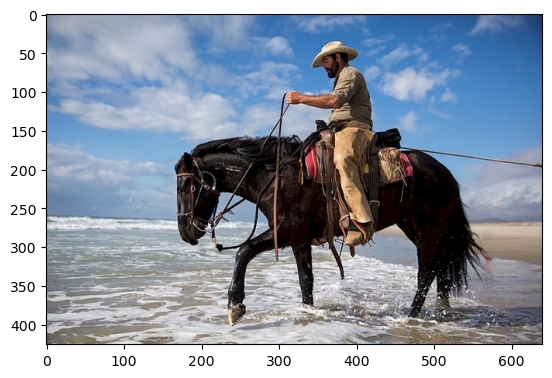

torch.Size([1, 21, 200, 5])
tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0195, 0.0121, 0.8325, 0.1498, 0.9729],
          [0.0115, 0.4305, 0.2309, 0.5102, 0.3969],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0670, 0.7310, 0.7857, 0.8504, 0.9431],
          [0.0482, 0.2568, 0.3209, 0.8609, 0.9024],
          [0.0235, 0.2334, 0.4086, 0.3535, 0.7434],
          ...,
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.00

C:\Users\82102\pytorch_advanced\2_objectdetection\utils\ssd_model.py:590: UserWarning: An output with one or more elements was resized since it had shape [46], which does not match the required output shape [38]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Resize.cpp:35.)
  torch.index_select(x1, 0, idx, out=tmp_x1)
C:\Users\82102\pytorch_advanced\2_objectdetection\utils\ssd_model.py:591: UserWarning: An output with one or more elements was resized since it had shape [46], which does not match the required output shape [38]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.

In [3]:
from utils.ssd_model import DataTransform

# 1. 画像読み込み
image_file_path = "./data/cowboy-757575_640.jpg"
img = cv2.imread(image_file_path)  # [高さ][幅][色BGR]
height, width, channels = img.shape  # 画像のサイズを取得

# 2. 元画像の表示
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# 3. 前処理クラスの作成
color_mean = (104, 117, 123)  # (BGR)の色の平均値
input_size = 300  # 画像のinputサイズを300×300にする
transform = DataTransform(input_size, color_mean)

# 4. 前処理
phase = "val"
img_transformed, boxes, labels = transform(
    img, phase, "", "")  # アノテーションはないので、""にする
img = torch.from_numpy(img_transformed[:, :, (2, 1, 0)]).permute(2, 0, 1)

# 5. SSDで予測
net.eval()  # ネットワークを推論モードへ
x = img.unsqueeze(0)  # ミニバッチ化：torch.Size([1, 3, 300, 300])
detections = net(x)

print(detections.shape)
print(detections)

# output : torch.Size([batch_num, 21, 200, 5])
#  =（batch_num、クラス、confのtop200、規格化されたBBoxの情報）
#   規格化されたBBoxの情報（確信度、xmin, ymin, xmax, ymax）


In [3]:
# 画像に対する予測
from utils.ssd_predict_show import SSDPredictShow

# ファイルパス
image_file_path = "./data/cowboy-757575_640.jpg"

# 予測と、予測結果を画像で描画する
ssd = SSDPredictShow(eval_categories=voc_classes, net=net)
ssd.show(image_file_path, data_confidence_level=0.6)



RuntimeError: Legacy autograd function with non-static forward method is deprecated. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)

以上